# ①ボックスのピクセル値の変化で判別する方法

In [55]:
from typing import Final as const, Any
from dataclasses import dataclass
import numpy as np
import math



In [56]:
#openCVによるチェックマークの認識テスト
import cv2
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import japanize_matplotlib
from boxdetect.pipelines import get_checkboxes, get_boxes
from boxdetect import config

In [71]:
#画像の取り込みとリサイズ
file_name: str = "../samples/DSC_0454.JPG" #認識するシートのファイル名
size_wh: tuple[int, int] = (748, 1058)

image = cv2.imread(file_name)
image = cv2.resize(image, size_wh)
#image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

In [72]:
def plot_image(img: Any, plt_size: tuple[int, int] = (5, 5), title: str = None) -> None:
    """
    画像を表示する
    """
    fig, ax = plt.subplots(figsize=plt_size)
    ax.set_title(title)
    ax.imshow(img)
    plt.show()

def plot_img_flex(imgs: list[Any], plt_size: tuple[int, int] = (5, 5), title: str = None) -> None:
    """_summary_
    画像を横に並べて表示する
    """
    fig, axs = plt.subplots(1, len(imgs), figsize=plt_size)
    fig.suptitle(title)
    for i, img in enumerate(imgs):
        #index番号をつける
        axs[i].set_title(f"No.{i}")
        axs[i].imshow(img)
    plt.show()


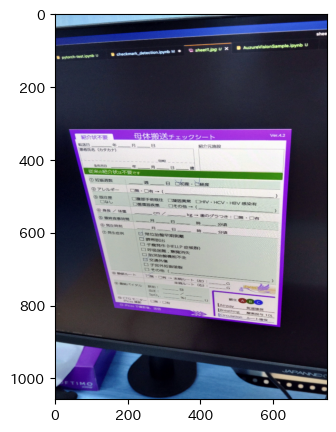

In [73]:
#オリジナル画像の表示
plot_image(image)

## 台形補正

紙面の輪郭抽出　→ 4角の座標を検知→台形補正

In [77]:
#紙面の領域を認識する関数を作成
def detect_paper(image):
    
    img = image.copy()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    plot_image(gray)


#指定座標の台形補正を行う関数
def perspective_correction(image: Image, points: list[list[float]]):
    """_summary_
    指定4点座標間の台形補正を行う
    Args:
        image (Image): 変換対象画像
        points (list[list[float]]): 変換対象を囲う4点座標
        [
            左上,
            右上,
            右下,
            左下
        ]
    """
    img = cv2.imread(image)

    # 画像の高さと幅を取得
    #比率
    h_ratio = 1
    w_ratio = 1
    #　幅取得
    width = np.linalg.norm(points[1] - points[0])
    width = math.floor(width * w_ratio)
    
    #　高さ取得
    height = np.linalg.norm(points[2] - points[0])
    height = math.floor(height)

    # 変換前の4点
    src = np.float32(points)
    
    # 変換後の4点
    dst = np.float32([[0, 0],[width, 0],[0, height],[width, height]])
    
    # 変換行列
    M = cv2.getPerspectiveTransform(src, dst)
    
    # 射影変換・透視変換する
    output = cv2.warpPerspective(img, M,(width, height))

    return output

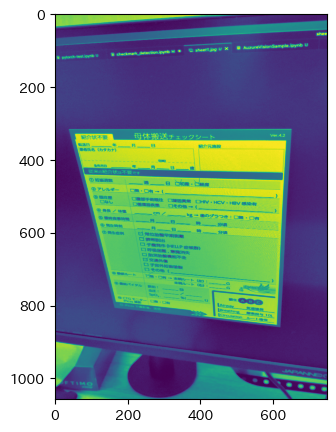

In [78]:
detect_paper(image)


## チェックボックスの認識

In [62]:

#checkboxの検出パラメータ設定
cfg = config.PipelinesConfig() #インスタンス生成

#検出する四角形のwidthとheightの範囲指定
# ここでは、チェックボックスが正方形であると仮定して、幅と高さの範囲を同じに設定します
cfg.width_range = (12, 17)  
cfg.height_range = (12, 17)

# 検出する四角形のwidthとheightの比率の範囲を設定
cfg.wh_ratio_range = (0.9, 1.1)  # 正方形を想定しているので、比率は1.0に近い値を設定

# 検出する四角形のグループ化の閾値を設定（今回は０）
cfg.group_size_range = (0, 0)

# ダイレーション変換の反復回数を設定
cfg.dilation_iterations = 0  # 画像を強調表示するためにダイレーション変換を0回実行

# スケーリング因子を設定
cfg.scaling_factors = [1.0, 1.3, 10]  # 複数のスケーリング因子を使用して精度を向上


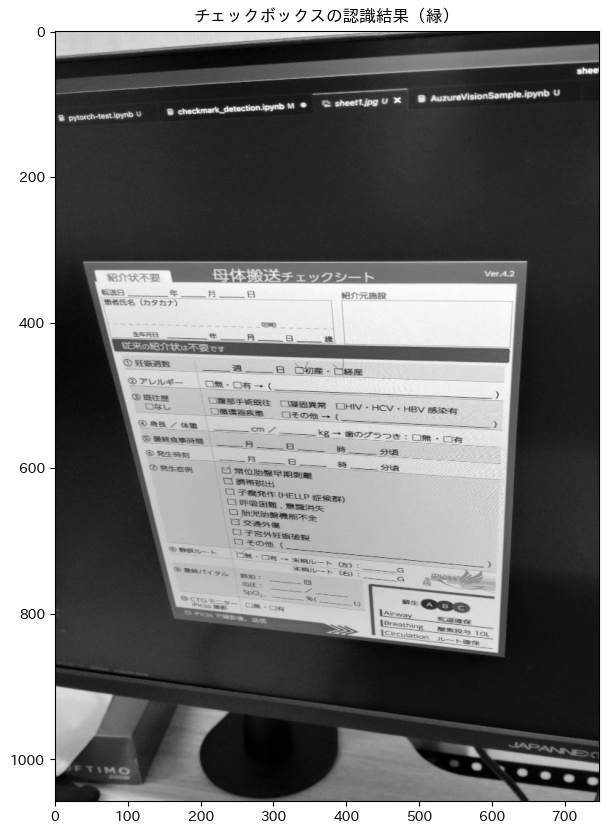

In [63]:
#検出処理
rects, grouping_rects, image, output_image = get_boxes(image, cfg=cfg, plot=False)

#検出結果の表示
plot_image(output_image, (10, 10), "チェックボックスの認識結果（緑）")

In [64]:
# 認識したチェックボックスの画像を切り出して、管理しやすいようクラスで管理

#rects: np.ndarray[np.ndarray[int]] #[[x1, y1, w, h], [x2, y2, w, h], ...]


def get_checkbox_image(rect: np.ndarray[int], image: Any) -> Any:
    """
    チェックボックスの画像を切り出す
    rect: np.ndarray[int] = [x, y, w, h]
    image: Any = 元画像
    """
    x, y, w, h = rect
    return image[y:y+h, x:x+w]

@dataclass
class Checkbox:
    rect: np.ndarray[int] #元画像内での座標情報
    image: Any #切り出したチェックボックスの画像
    is_checked: bool = False #チェックマークが入っているかどうか

checkboxes: list[Checkbox] = []

for rect in rects:
    checkbox_image = get_checkbox_image(rect, image)
    checkbox = Checkbox(rect, checkbox_image)
    checkboxes.append(checkbox)

#チェックボックスの画像を表示
plot_img_flex([checkbox.image for checkbox in checkboxes], plt_size=(40, 2),title="チェックボックスの画像")

print(f'認識したチェックボックスの数：{len(checkboxes)}')

#NOTE:一部重複認識があるが、今回はチェックマークの有無を判定するので問題なし



TypeError: 'type' object is not subscriptable

## チェックボックスのマーク判定処理

In [ ]:
#切り出したチェックボックスの外枠が、マーク有無の判定に影響するので、外枠を削除する
def remove_frame(checkbox: Checkbox, trim_px: int) -> Checkbox:
    
    # 切り出したチェックボックスの画像を読み込む
    checkbox_img = checkbox.image
    # トリミングするピクセル数を設定する
    trim_size = trim_px

    # 画像の高さと幅を取得する
    h, w = checkbox_img.shape

    # 画像をトリミングする
    trimmed_img = checkbox_img[trim_size:h-trim_size, trim_size:w-trim_size]
    #座標情報を更新
    checkbox.rect[0] += trim_size
    checkbox.rect[1] += trim_size
    checkbox.rect[2] -= trim_size * 2
    checkbox.rect[3] -= trim_size * 2

    return Checkbox(checkbox.rect, trimmed_img)

In [ ]:
#判定しやすくするため、画像を2値化する関数を定義

from enum import Enum

class BinarySolution(Enum):
    """_summary_
    二値化の手法を定義
    """
    BINARY = cv2.THRESH_BINARY  # ピクセル値が閾値より大きい場合はmaxValに、それ以外の場合は0に設定します。
    BINARY_INV = cv2.THRESH_BINARY_INV  # ピクセル値が閾値より大きい場合は0に、それ以外の場合はmaxValに設定します。
    THRESH_TRUNC = cv2.THRESH_TRUNC  # ピクセル値が閾値より大きい場合は閾値に、それ以外の場合はそのままにします。
    THRESH_TOZERO = cv2.THRESH_TOZERO  # ピクセル値が閾値より大きい場合はそのままに、それ以外の場合は0に設定します。
    THRESH_TOZERO_INV = cv2.THRESH_TOZERO_INV  # ピクセル値が閾値より大きい場合は0に、それ以外の場合はそのままにします。


def conv_binary(check_box: Checkbox, threshold: float, solution: BinarySolution=BinarySolution.BINARY) -> Checkbox:
    """_summary_
    チェックボックスの画像を二値化する
    """
    _, binary_img = cv2.threshold(check_box.image, threshold, 255, solution.value)
    return Checkbox(check_box.rect, binary_img)

In [ ]:
# 切り出した画像のピクセル値を2値化して、チェックマークがあるかどうかを判定する
def is_mark(box: Checkbox, min_threshold: float, max_threshold: float) -> tuple[bool, float, Any]:
    """
    チェックボックスの画像からチェックマークがあるかどうかを判定する
    Args:
        checkbox: Checkbox = チェックボックス
        min_threshold: float = マーク有と判定するための、塗られている割合の下限（0.0〜1.0）
        max_threshold: float = マーク有と判定するための、塗られている割合の上限（0.0〜1.0）
    """
    checkbox = box.image
    # 黒いピクセルの数を数える（白い背景に黒いチェックマークを想定）
    black_pixels = np.count_nonzero(checkbox == 0)
    
    # black_pixelsの割合を計算
    ratio = black_pixels / (checkbox.shape[0] * checkbox.shape[1])

    # チェックマークの割合が閾値を超えていれば、チェックマークありと判定
    if min_threshold <= ratio <= max_threshold:
        box.is_checked = True
    else:
        box.is_checked = False

    return (box.is_checked, ratio, checkbox)



In [ ]:
import copy
#検証のためcheckboxのリストをコピー
checkboxes_copy = copy.deepcopy(checkboxes)

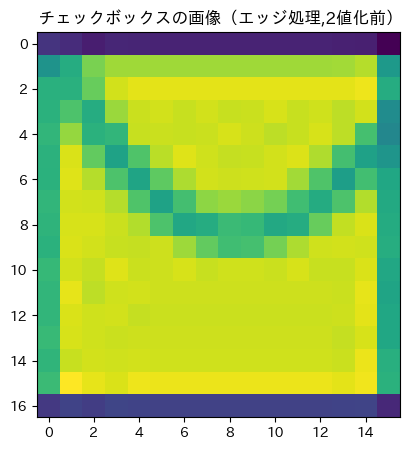

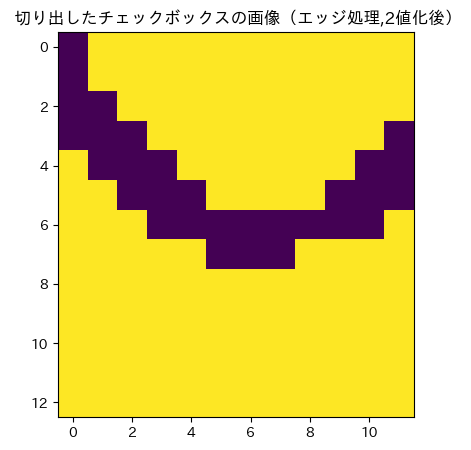

judge: True, mark_raito: 0.19230769230769232


In [ ]:
#しっかりとマークされているサンプルで検証
sample_box = checkboxes_copy[8]
plot_image(sample_box.image, title=" チェックボックスの画像（エッジ処理,2値化前）")
sample_box = conv_binary(sample_box, 200)
sample_box = remove_frame(sample_box, 2)
judge, mark_raito, box_img = is_mark(sample_box, 0.05, 0.2) #判定サンプル
plot_image(box_img, title=" 切り出したチェックボックスの画像（エッジ処理,2値化後）")
print(f"judge: {judge}, mark_raito: {mark_raito}")


#is_mark(checkboxes[23], 0.3, 0.5)

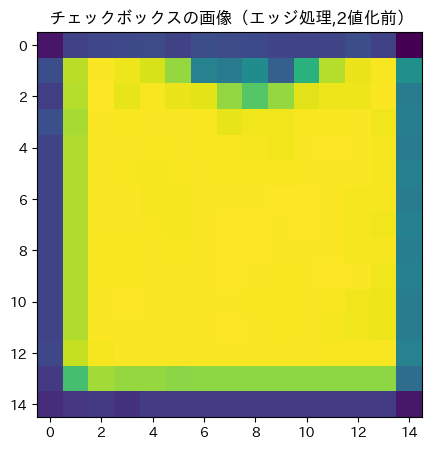

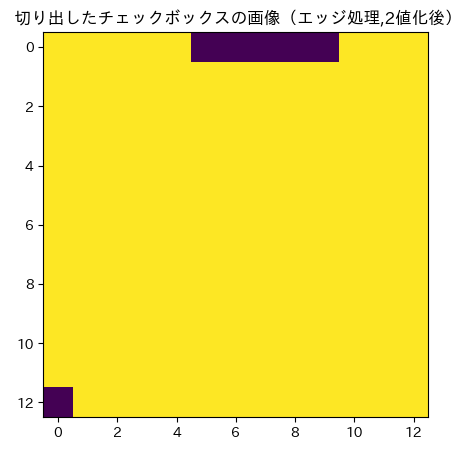

judge: True, mark_raito: 0.03550295857988166


In [ ]:
# 際どいサンプル(チェックあり)で検証

sample_box = checkboxes_copy[5]
plot_image(sample_box.image, title=" チェックボックスの画像（エッジ処理,2値化前）")
sample_box = conv_binary(sample_box, 200)
sample_box = remove_frame(sample_box, 1)
judge, mark_raito, box_img = is_mark(sample_box, 0.03, 0.2) #判定サンプル
plot_image(box_img, title=" 切り出したチェックボックスの画像（エッジ処理,2値化後）")
print(f"judge: {judge}, mark_raito: {mark_raito}")

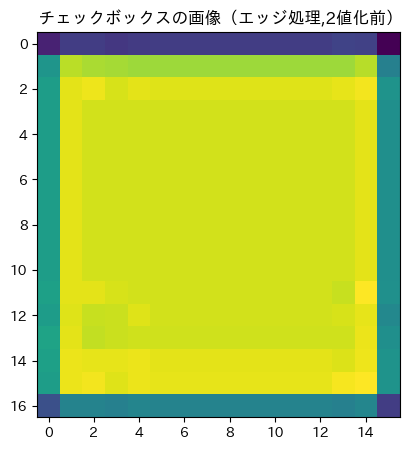

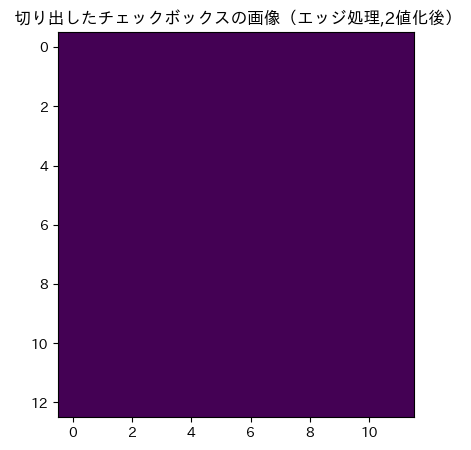

judge: False, mark_raito: 0.0


In [ ]:
# チェックの無いサンプルで検証

sample_box = checkboxes_copy[10]
plot_image(sample_box.image, title=" チェックボックスの画像（エッジ処理,2値化前）")
sample_box = conv_binary(sample_box, 200)
sample_box = remove_frame(sample_box, 2)
judge, mark_raito, box_img = is_mark(sample_box, 0.05, 0.2) #判定サンプル
plot_image(box_img, title=" 切り出したチェックボックスの画像（エッジ処理,2値化後）")
print(f"judge: {judge}, mark_raito: {mark_raito}")

## 検証判定

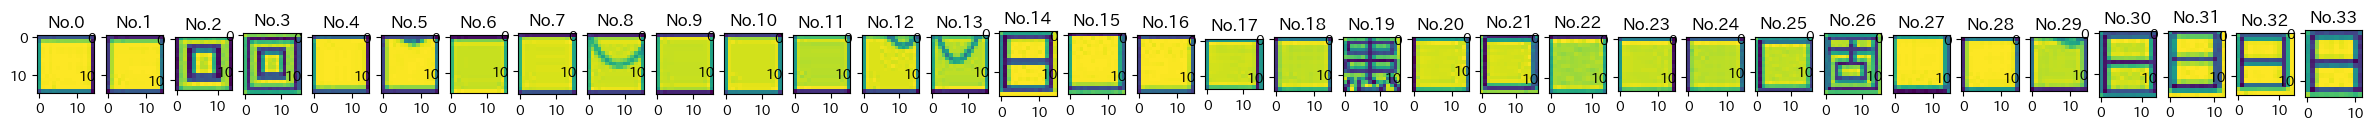

No2. judge : True, mark_raito : 0.3939393939393939
No5. judge : True, mark_raito : 0.03550295857988166
No8. judge : True, mark_raito : 0.17142857142857143
No12. judge : True, mark_raito : 0.061224489795918366
No13. judge : True, mark_raito : 0.15306122448979592
No14. judge : True, mark_raito : 0.49230769230769234
No15. judge : True, mark_raito : 0.14285714285714285
No17. judge : True, mark_raito : 0.07142857142857142
No21. judge : True, mark_raito : 0.30666666666666664
No25. judge : True, mark_raito : 0.3047619047619048
No27. judge : True, mark_raito : 0.14792899408284024
No29. judge : True, mark_raito : 0.05128205128205128
No30. judge : True, mark_raito : 0.4642857142857143
No31. judge : True, mark_raito : 0.46153846153846156
No33. judge : True, mark_raito : 0.4666666666666667


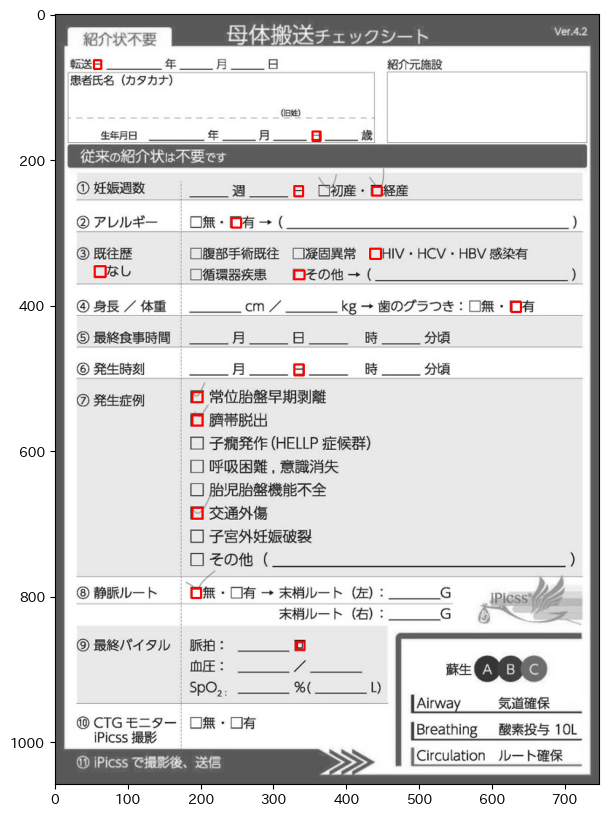

In [ ]:
# チェックマークの有無を判定して、結果をプロット表示する
#TODO：OCRでテキスト認識するやつは除外するようにする。

#ハイパーパラメータ設定（枠内にチェックが塗られている割合・外枠をトリムするpx値）
MIN_THRESHOLD: const[float] = 0.03
MAX_THRESHOLD: const[float] = 0.5
TRIM_SIZE: const[int] = 1

#元画像を元のグレースケールに戻す
image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
plot_img_flex([checkbox.image for checkbox in checkboxes], (30, 3))

    
for i, box in enumerate(checkboxes):

    box = conv_binary(box, 200)
    box = remove_frame(box, TRIM_SIZE)
    
    judge, mark_raito, box_img  = is_mark(box, MIN_THRESHOLD, MAX_THRESHOLD)
    #plot_image(box_img)
    if box.is_checked:
        print(f"No{i}. judge : {judge}, mark_raito : {mark_raito}")
        #plot_image(box_img, (10, 10))
        plot_color = (255,0,0)
        #元画像にチェックマークの有無をプロット
        x, y, w, h = box.rect
        cv2.rectangle(image, (x, y), (x+w, y+h), plot_color, 2)
    else:
        #plot_color = (0,0,255)
        pass

#結果を表示（true:赤）
plot_image(image, (10, 10))


## 検出したチェックボックスとOCRで認識した文字列を統合して認識させる


In [ ]:
#